In [1]:
import math
import os
import json

import torch
from torch import nn, optim
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

from typing import List, Dict

In [2]:
from src.env import PuzzleEnv
from src.agent import OneStepAgent, Agent
from src.dqn import DQN
from src.visualization.plotting import (
    imshow_cube,
    plot_history,
    plot_success_length,
    plot_success_rate,
)
from src.train.result_utils import ResultManager, save_history

In [3]:
device = "cpu"

For DQN we'll use a simple FFN similar to dist_predictor


In [4]:
env_config = {
    "exp_name": "C2_m14_n10",
    "puzzle_name": "cube_2x2x2",
    "num_envs": 256,
    "max_steps": 30,
    "reset_config": {
        "sampler": "uniform",
        "shuffle_range": [1, 15],
        "extra_generation": 8,
    },
    "reward_config": {
        "success": 10,
        "time": 0,
    },
    "state_repr": "color",
}

env = PuzzleEnv(env_config)

agent_config = {
    "alg": "DQN",
    "double": True,
    "inp": env.state_size,
    "oup": env.num_actions,
    "batch_size": env.num_envs,
    "gamma": 0.99,
    "n": 10,
    "epsilon": {
        "schedule": "exp",
        "start": 0.9,
        "end": 0.05,
        "decay": 50000,  # 50000
    },
    "target_network": {
        "tau": 1,
        "delay": 5000,
    },
    "lr": 1e-4,
    "weight_decay": 0,
    "optimizer": "adam",
    "network_units": [256, 512, 256],
    "activation": "relu",
    "noisy_net": False,
}

Loaded cube_2x2x2: 12 actions, 24 states


In [5]:
# initiate history template
history = {
    "reward": [],
    "avg_success": [],
    "loss": [],
    "success_per_n": {
        f"{n}": [] for n in range(*env_config["reset_config"]["shuffle_range"])
    },
    "success_length_per_n": {
        f"{n}": [] for n in range(*env_config["reset_config"]["shuffle_range"])
    },
}


def train(env, agent, history, episodes, episode_length=20, dry_run=0):
    s = env.reset()
    s = torch.tensor(s, device=device)
    for _ in tqdm(range(env.max_steps)):
        # reset 10% of the environment every turn to decorrelate data
        reset_indices = list(
            np.random.randint(0, env.num_envs, int(0.1 * env.num_envs))
        )
        s = env.reset(reset_indices)
        s = torch.tensor(s, device=device)
        a = agent.select_action(s)
        s_n, r, terminated, mask = env.step(a)
        s_n = torch.tensor(s_n, device=device)
        agent._update_history(s, s_n, a, r, mask, terminated)
        s = s_n
    for _ in tqdm(range(dry_run)):
        a = agent.select_action(s)
        s_n, r, terminated, mask = env.step(a)
        s_n = torch.tensor(s_n, device=device)
        agent._update_history(s, s_n, a, r, mask, terminated)
        s = s_n
    if dry_run > 0:
        print(f"Completed dry run for {dry_run} steps")
    for _ in tqdm(range(episodes)):
        for _ in range(episode_length):
            # for _ in range(1):
            a = agent.select_action(s)
            s_n, r, terminated, mask = env.step(a)
            s_n = torch.tensor(s_n, device=device)

            loss = agent.optimize(s, a, r, s_n, terminated, mask)
            s = s_n

        # agent.update_target_net()

        history["loss"].append(loss)
        history["reward"].append(env.get_cumulative_reward().mean().item())
        (
            success_rate_per_n,
            success_length_per_n,
            average_success,
        ) = env.get_completion_rate()
        history["avg_success"].append(average_success)
        for n in success_rate_per_n.keys():
            history["success_per_n"][f"{n}"].append(success_rate_per_n[n])
            history["success_length_per_n"][f"{n}"].append(success_length_per_n[n])


def load_experiment(exp_folder):
    for f in [
        "env_config.json",
        "agent_config.json",
        "history.json",
        "target_net.pt",
        "policy_net.pt",
    ]:
        if f not in os.listdir(exp_folder):
            print(f"Warning: did not find {f} in {exp_folder}")
            return
    print("found all files, loading configs...")
    with open(os.path.join(exp_folder, "env_config.json"), "r+") as f:
        env: PuzzleEnv = PuzzleEnv(json.load(f))
    with open(os.path.join(exp_folder, "agent_config.json"), "r+") as f:
        agent: Agent = Agent(json.load(f))

    print("loading network checkpoints...")
    agent.target_network = torch.load(os.path.join(exp_folder, "target_net.pt"))
    agent.policy_network = torch.load(os.path.join(exp_folder, "policy_net.pt"))
    agent.optimizer = torch.load(os.path.join(exp_folder, "optimizer.pt"))

    with open(os.path.join(exp_folder, "history.json")) as f:
        history = json.load(f)
    print("successfully loaded checkpoint")
    return env, agent, history

In [6]:
from collections import deque


class NStepAgent(Agent):
    def __init__(self, config):
        super().__init__(config)

        self.n = config["n"]
        self._init_history()

    def _init_history(self):
        """Initiates the tensors for tracking episode history"""
        b, n = self.batch_size, self.n
        # we use a deque for state because it's cheaper & we don't need access to
        # intermediate values for compute, its shape is n x b x |S|
        # self.s = deque([torch.rand((b, self.num_states))], maxlen=n)
        self.s = torch.rand((b, n, self.num_states))
        self.s_n = torch.rand((b, n, self.num_states))
        self.a = torch.zeros((b, n, 1), dtype=int)
        self.r = torch.zeros((b, n, 1), dtype=torch.float32)
        # mask: 1 if (s, a, s') is an invalid transition
        self.m = torch.zeros((b, n, 1), dtype=torch.float32)
        # terminate: 1 if (s, a, s') and s' is successful
        self.t = torch.zeros((b, n, 1), dtype=torch.float32)

        # tracks G_t:t+n for every state
        self.G = torch.zeros((b, n, 1))
        # 1 if state s is part of the current episode
        self.episode_mask = torch.zeros((b, n, 1), dtype=torch.float32)
        # indicates the relative distance (to the right) to the end of episode
        # if the distance is larger than n we can simply apply min() when retrieving
        self.episode_end_idx = torch.zeros((b, n, 1), dtype=int)

        self.discount = self.gamma ** torch.arange(n - 1, -1, -1)
        self.discount = self.discount.unsqueeze(0).unsqueeze(-1)

    def _update_history(self, s, s_n, a, r, m, t):
        # reshape tensors
        s = s.unsqueeze(dim=1)
        s_n = s_n.unsqueeze(dim=1)
        a = a[..., None, None]
        r = r[..., None, None]
        t = t[..., None, None]
        m = m[..., None, None]

        # push everything to queue
        # self.s.append(s)
        self.s = torch.cat((self.s[:, 1:], s), dim=1)
        self.s_n = torch.cat((self.s_n[:, 1:], s_n), dim=1)
        self.a = torch.cat((self.a[:, 1:], a), dim=1)
        self.r = torch.cat((self.r[:, 1:], r), dim=1)
        self.m = torch.cat((self.m[:, 1:], m), dim=1)
        self.t = torch.cat((self.t[:, 1:], t), dim=1)

        self.G = torch.cat((self.G[:, 1:], torch.zeros_like(self.G[:, 0:1])), dim=1)

        inv_m = (m - 1) * -1  # 0 if episode ended, 1 if episode is continuing
        self.episode_mask *= inv_m  # zeros the row if episode ended
        self.episode_end_idx += self.episode_mask.long()
        self.episode_mask = torch.cat((self.episode_mask[:, 1:], inv_m), dim=1)

        self.episode_end_idx = torch.cat(
            (
                self.episode_end_idx[:, 1:],
                torch.zeros_like(self.episode_end_idx[:, 0:1]),
            ),
            dim=1,
        )

        # add reward to ongoing episodes
        self.G += self.discount * r * self.episode_mask

    def optimize(self, s, a, r, s_n, terminated, mask):
        if self.noisy:
            self.policy_network.reset_noise()
            self.target_network.reset_noise()
        self._update_history(s, s_n, a, r, mask, terminated)

        s_t = self.s[:, 0]
        a_t = self.a[:, 0]
        m_t = self.m[:, 0]

        G_tpn = self.G[:, 0]
        # (b, 1, 1)
        tpn_idx = self.episode_end_idx[:, 0].unsqueeze(-1)
        tpn_idx = torch.where(
            tpn_idx > self.n, torch.ones_like(tpn_idx) * (self.n), tpn_idx
        )
        # (b, |S|)
        s_tpn = self.s_n.gather(1, tpn_idx.repeat(1, 1, self.num_states)).squeeze(1)
        # (b, 1)
        t_tpn = self.t.gather(1, tpn_idx).squeeze(1)
        with torch.no_grad():
            # a_tpn = self.a.gather(1, self.episode_end_idx[:, 0].unsqueeze(-1)).squeeze()
            if self.use_double:
                greedy_a = self.policy_network(s_tpn).argmax(axis=-1)
                max_Q_s_tpn = self.target_network(s_tpn).gather(
                    1, greedy_a.unsqueeze(-1)
                )
            else:
                max_Q_s_tpn = (
                    self.target_network(s_tpn).max(axis=-1).values.unsqueeze(-1)
                )

        # mask out terminal states
        max_Q_s_tpn = torch.where(
            t_tpn == 1, torch.zeros_like(max_Q_s_tpn), max_Q_s_tpn
        )
        target = G_tpn + self.gamma ** tpn_idx.squeeze(1) * max_Q_s_tpn

        # Q(s_t, a_t)
        Q = self.policy_network(s_t).gather(1, a_t)

        loss = self.criterion(Q, target)
        # apply mask on loss
        loss = torch.where(m_t == 1, torch.zeros_like(loss), loss).mean()

        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_network.parameters(), 10)
        self.optimizer.step()

        self.steps += 1

        if self.steps % self.target_net_delay == 0:
            self.update_target_net()

        return loss.item()

In [7]:
history = {
    "reward": [],
    "avg_success": [],
    "loss": [],
    "success_per_n": {
        f"{n}": [] for n in range(*env_config["reset_config"]["shuffle_range"])
    },
    "success_length_per_n": {
        f"{n}": [] for n in range(*env_config["reset_config"]["shuffle_range"])
    },
}
ec = env_config.copy()
ac = agent_config.copy()

env = PuzzleEnv(ec)
agent = NStepAgent(ac)
# agent = OneStepAgent(ac)

train(env, agent, history, episodes=500, episode_length=ec["max_steps"], dry_run=10)
# train(env, agent, history, episodes=200, episode_length=50, dry_run=10)
# train(env, agent, history, episodes=1, episode_length=1, dry_run=25)
print(sum(history["avg_success"][-100:]) / len(history["avg_success"][-100:]))
# print(history["avg_success"][-1])

Loaded cube_2x2x2: 12 actions, 24 states


100%|██████████| 10/10 [00:00<00:00, 342.00it/s]


Completed dry run for 10 steps


100%|██████████| 500/500 [01:25<00:00,  5.83it/s]

0.04688337057477679


In [16]:
train(env, agent, history, episodes=5000, episode_length=ec["max_steps"], dry_run=500)
print(sum(history["avg_success"][-100:]) / len(history["avg_success"][-100:]))

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:01<00:00, 315.55it/s]


Completed dry run for 500 steps


100%|██████████| 5000/5000 [20:50<00:00,  4.00it/s]

0.4185156250390624


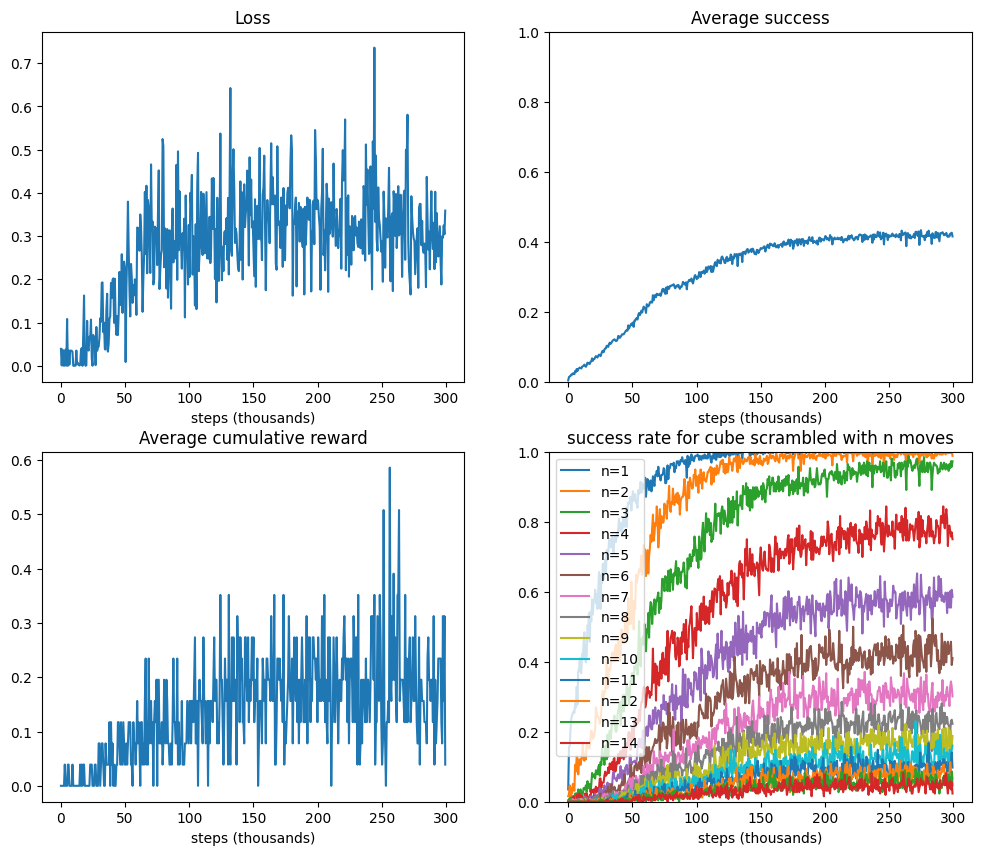

In [17]:
plot_history(history, episode_length=30)

In [18]:
# env, agent, history = load_experiment("results/C3_m10_64envs_1000")
env.config['exp_name'] = "C2_m14_n10_300"
result_manager = ResultManager(agent, env)

creating new experiment folder C2_m14_n10_300


saving configs...
saved env and agent configs
saving networks...
saved policy network and target networks


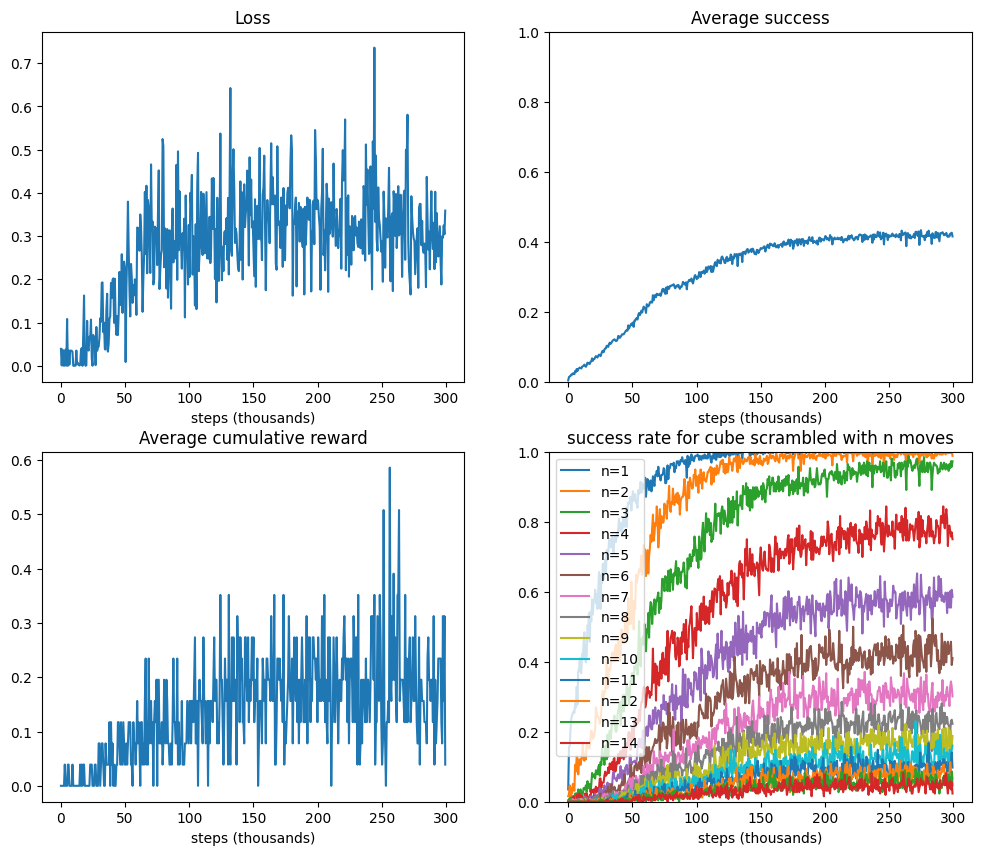

In [19]:
result_manager.save()
eps_len = result_manager.env.max_steps
save_history(history, result_manager.directory)
plot_history(history, episode_length=eps_len, save_to_folder=result_manager.directory)

In [23]:
# result_manager.agent.policy_network.eval()
# result_manager.agent.policy_network.train()
eval_stats = result_manager.evaluate(steps=1000)
# result_manager.agent.policy_network.train()

sum(eval_stats["avg_success"][-100:]) / 100

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 317.25it/s]


0.21941406253906262

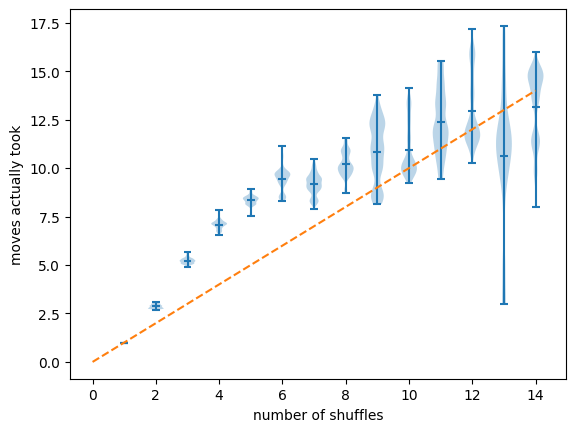

In [24]:
plot_success_length(eval_stats["success_length_per_n"], save_to_folder=result_manager.directory)
# plot_success_length(eval_stats["success_length_per_n"], save_to_folder=None)

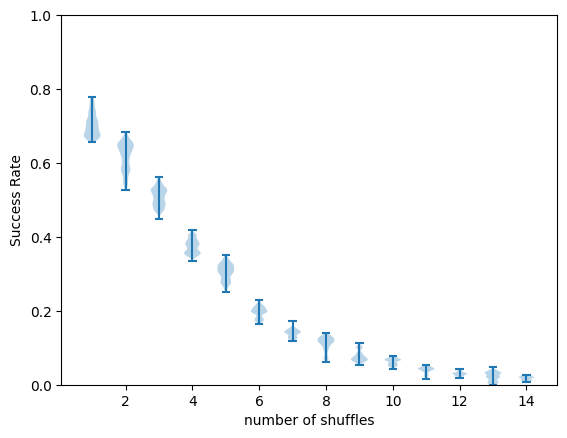

In [25]:
plot_success_rate(eval_stats["success_per_n"], save_to_folder=result_manager.directory)
# plot_success_rate(eval_stats["success_per_n"], save_to_folder=None)

### Dive into inference more

In [ ]:
from src.mechanism.utils import get_inverse_move

sample_state = env.states[0]
sample_shuffle = env.gt_moves[0]

print(sample_shuffle)
print(env.action_names)

inv_move = get_inverse_move(sample_shuffle[0])
idx = list(env.action_names).index(inv_move)
print(f"inverse move {inv_move} on index {idx}")
env.step([idx])

In [ ]:
env.step([0])

sample_state = env.states[0]

print(env.states[0])
print(env.gt_moves[0])

In [121]:
# treating tensors as queues
a = torch.randint(1, 10, (256, 10, 1))
a_next = torch.randint(0, 1, (256, 10, 1))

%timeit -n 1000 torch.cat((a[:, 1:], a_next), dim=1)

6.4 µs ± 592 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [212]:
b = 128
n = 10
a = torch.randint(1, 99, (b, n, 1))
# s = torch.randint(1, 10, (b, n, 24))
r = torch.rand((b, n, 1))
m = torch.randint(0, 1, (b, n, 1))
t = torch.randint(0, 1, (b, n, 1))

s_n = torch.randint(1, 99, (b, 1, 24))
s = deque([s_n] * n, maxlen=n)


def update(a, s, r, m, t):
    a_n = torch.randint(1, 99, (b, 1, 1))
    s_n = torch.randint(1, 99, (b, 1, 24))
    r_n = torch.rand((b, 1, 1))
    m_n = torch.randint(0, 1, (b, 1, 1))
    t_n = torch.randint(0, 1, (b, 1, 1))
    # s = torch.cat((s[:, 1:], s_n), dim=1)
    s.append(s_n) # a lot faster, this is the biggest tensor & we only need to read it
    a = torch.cat((a[:, 1:], a_n), dim=1)
    r = torch.cat((r[:, 1:], r_n), dim=1)
    m = torch.cat((m[:, 1:], m_n), dim=1)
    t = torch.cat((t[:, 1:], t_n), dim=1)
    return s, a, r, m, t

%timeit -n 1000 update(a, s, r, m, t)

36.1 µs ± 1.99 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [89]:
b = 256
n = 10
GAMMA = 0.99

a = torch.randint(1, 99, (b, n, 1))
# s = torch.randint(1, 10, (b, n, 24))
r = torch.rand((b, n, 1))
m = torch.randint(0, 1, (b, n, 1))
t = torch.randint(0, 1, (b, n, 1))

s_n = torch.randint(1, 99, (b, 1, 24))
s = deque([s_n] * n, maxlen=n)

G = torch.zeros((b, n, 1))


def update(s, a, r, m, t, s_n, a_n, r_n, m_n, t_n):
    # s = torch.cat((s[:, 1:], s_n), dim=1)
    s.append(s_n)  # a lot faster, this is the biggest tensor & we only need to read it
    a = torch.cat((a[:, 1:], a_n), dim=1)
    r = torch.cat((r[:, 1:], r_n), dim=1)
    m = torch.cat((m[:, 1:], m_n), dim=1)
    t = torch.cat((t[:, 1:], t_n), dim=1)
    return s, a, r, m, t


episode_mask = torch.zeros((b, n, 1), dtype=int)
episode_end_idx = torch.zeros((b, n, 1), dtype=int)

def step(s, a, r, m, t):
    global episode_mask
    global episode_end_idx
    global G
    a_n = torch.randint(1, 99, (b, 1, 1))
    s_n = torch.randint(1, 99, (b, 1, 24))
    r_n = torch.rand((b, 1, 1))
    m_n = torch.empty((b, 1, 1), dtype=int).bernoulli(p=0.1)
    t_n = torch.empty((b, 1, 1), dtype=int).bernoulli(p=0.1)

    # failed = t[:, -1:, :] & m_n

    s, a, r, m, t = update(s, a, r, m, t, s_n, a_n, r_n, m_n, t_n)

    inv_m = (m_n - 1) * -1
    # inv_t = (t_n - 1) * -1

    G = torch.cat((G[:, 1:], torch.zeros_like(r_n)), dim=1)
    episode_mask *= inv_m

    episode_mask = torch.cat((episode_mask[:, 1:], inv_m), dim=1)
    episode_end_idx = torch.cat((episode_end_idx[:, 1:], torch.zeros_like(t_n)), dim=1)
    episode_end_increment = episode_mask
    episode_end_idx += episode_end_increment

    discount = GAMMA ** torch.arange(n - 1, -1, -1).unsqueeze(0).unsqueeze(-1)

    delta_G = discount * r_n * inv_m

    G += delta_G * episode_mask

    # print(m_n.squeeze())
    # print(episode_mask.squeeze())

%timeit -n 1000 step(s, a, r, m, t)

102 µs ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [81]:
episode_mask.squeeze()
# m[:, -1:, :]
i = 3
print(G.squeeze()[i])
print(episode_end_idx.squeeze()[i])
print(m.squeeze()[i])
print(r.squeeze()[i])

tensor([0.7595, 0.1921, 0.1686, 0.0385, 0.0000, 2.4969, 2.3662, 1.5486, 0.9621,
        0.1365])
tensor([4, 3, 2, 1, 0, 5, 4, 3, 2, 1])
tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
tensor([0.5693, 0.0252, 0.1305, 0.0385, 0.3826, 0.1544, 0.8330, 0.5962, 0.8269,
        0.1365])
